In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

from common.utils import load_data

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
data_dir = 'C:\\Users\\Bam\\Desktop\\Disertatie\\halfhourly_dataset'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-10-12 00:30:00,0
2012-10-12 01:00:00,0
2012-10-12 01:30:00,0
2012-10-12 02:00:00,0
2012-10-12 02:30:00,0


Reduce dataframe to a month worth of data

In [3]:
start_date = '2013-08-01 00:00:00'
end_date = '2013-09-01 00:00:00'

energy = energy.loc[start_date:end_date]

The train / test split data ratio is 80% / 20%

In [4]:
train_start_date = '2013-08-01 00:00:00'
test_start_date = '2013-08-25 19:00:00'

Visualize Energy Data

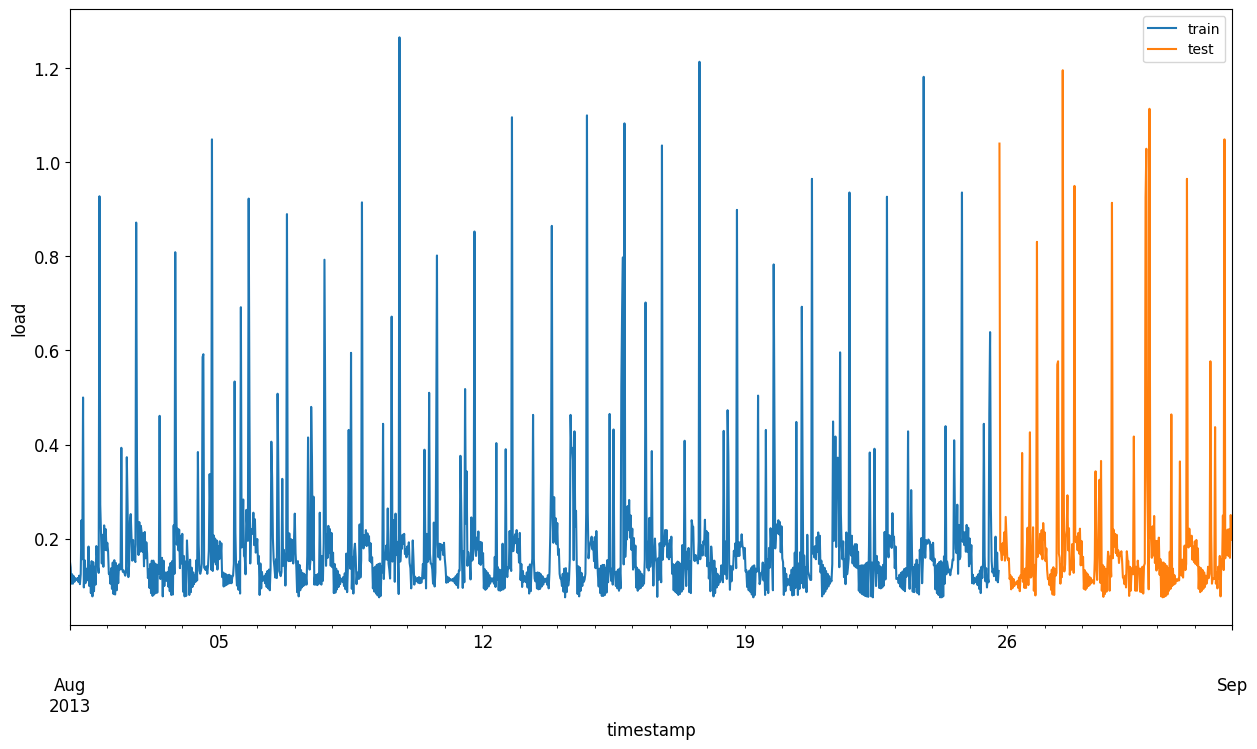

In [5]:
energy['load'] = pd.to_numeric(energy['load'])
energy[energy.index < test_start_date][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_date:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Load weather data from different source into Pandas Dataframe

In [6]:
weather = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\london_weather.csv')

weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M')

weather.tail(2900)

,date,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
0,2013-08-01 00:00:00,1.70,1012,15.80,100.00,3.10,15.80
1,2013-08-01 00:30:00,1.60,1012,15.60,100.00,3.00,15.60
2,2013-08-01 01:00:00,1.50,1012,15.40,100.00,3.00,15.40
3,2013-08-01 01:30:00,1.50,1012,15.30,100.00,3.00,15.30
4,2013-08-01 02:00:00,1.50,1011,15.10,100.00,3.00,15.10
...,...,...,...,...,...,...,...
1484,2013-08-31 22:00:00,2.40,1027,11.50,81.93,1.60,8.50
1485,2013-08-31 22:30:00,2.30,1027,11.30,83.02,1.50,8.50
1486,2013-08-31 23:00:00,2.20,1027,11.00,84.37,1.50,8.50
1487,2013-08-31 23:30:00,2.00,1027,10.60,86.64,1.50,8.50


Energy and Weather dataset integration and interpolation.

In [7]:
weather.set_index('date', inplace=True)

weather_energy = energy.merge(weather, how='left', left_index=True, right_index=True)

weather_energy.interpolate(method='time', inplace=True)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10


Feature Engineering

In [8]:
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')
peak_threshold = energy['load'].quantile(0.90)

bank_holidays = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\uk_bank_holidays.csv')
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays']).dt.date
bank_holiday_dates = set(bank_holidays['Bank holidays'])

weather_energy['hour'] = energy.index.hour
weather_energy['day_of_week'] = energy.index.dayofweek
weather_energy['month'] = energy.index.month
weather_energy['is_weekend'] = energy.index.dayofweek >= 5
weather_energy['is_peak_hour'] = np.where(energy['load'] >= peak_threshold, 1, 0)
weather_energy['is_bank_holiday'] = pd.Series(weather_energy.index.date).isin(bank_holiday_dates).values

# Lag features
weather_energy['previous_load'] = energy['load'].shift(1).fillna(0)
weather_energy['previous_is_peak_hour'] = weather_energy['is_peak_hour'].shift(1).fillna(0)
weather_energy['lag_1'] = energy['load'].shift(1).fillna(0)
weather_energy['rolling_mean_3'] = energy['load'].rolling(window=3).mean().fillna(0)
weather_energy['rolling_mean_2'] = energy['load'].rolling(window=2).mean().fillna(0)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point,hour,day_of_week,month,is_weekend,is_peak_hour,is_bank_holiday,previous_load,previous_is_peak_hour,lag_1,rolling_mean_3,rolling_mean_2
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80,0,3,8,False,0,False,0.00,0.00,0.00,0.00,0.00
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60,0,3,8,False,0,False,0.15,0.00,0.15,0.00,0.15
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40,1,3,8,False,0,False,0.14,0.00,0.14,0.13,0.12
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30,1,3,8,False,0,False,0.10,0.00,0.10,0.12,0.11
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10,2,3,8,False,0,False,0.12,0.00,0.12,0.11,0.11


Splitting the data into training and testing sets

In [9]:
train = weather_energy[(weather_energy.index >= train_start_date) & (weather_energy.index <= test_start_date)]
test = weather_energy[(weather_energy.index >= test_start_date)]

X_train = train.drop(columns=['load'])
y_train = train['load']

X_test = test.drop(columns=['load'])
y_test = test['load']

Building, Training and Using the Model

In [10]:
# Custom wrapper for Keras model compatible with scikit-learn
class KerasRegressorWrapper(BaseEstimator):
    def __init__(self, build_fn, epochs=50, batch_size=10, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define the RNN model
def build_rnn():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a transformer to scale the input data
class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)

# Define the pipeline without reshaping
pipeline = Pipeline([
    ('scaler', ScalerTransformer()),
    ('selector', SelectKBest(score_func=f_regression)),
    ('rnn', KerasRegressorWrapper(build_rnn))
])

# Define the parameter grid
param_grid = {
    'selector__k': [1, 3, 6],
    'rnn__epochs': [50, 100],
    'rnn__batch_size': [10, 20]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the grid search with the original input data (X_train and y_train)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict energy consumption on the test set
y_pred = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [11]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
print(f"Mean Squared Error: {mse}")
print('MAPE for testing data: ', mape * 100, '%')
print(f"R2 score for testing data: {r2}")

Mean Absolute Error: 0.0028836098036239778
Mean Squared Error: 1.7008040211010534e-05
MAPE for testing data:  1.9022666317685697 %
R2 score for testing data: 0.9994122080257041


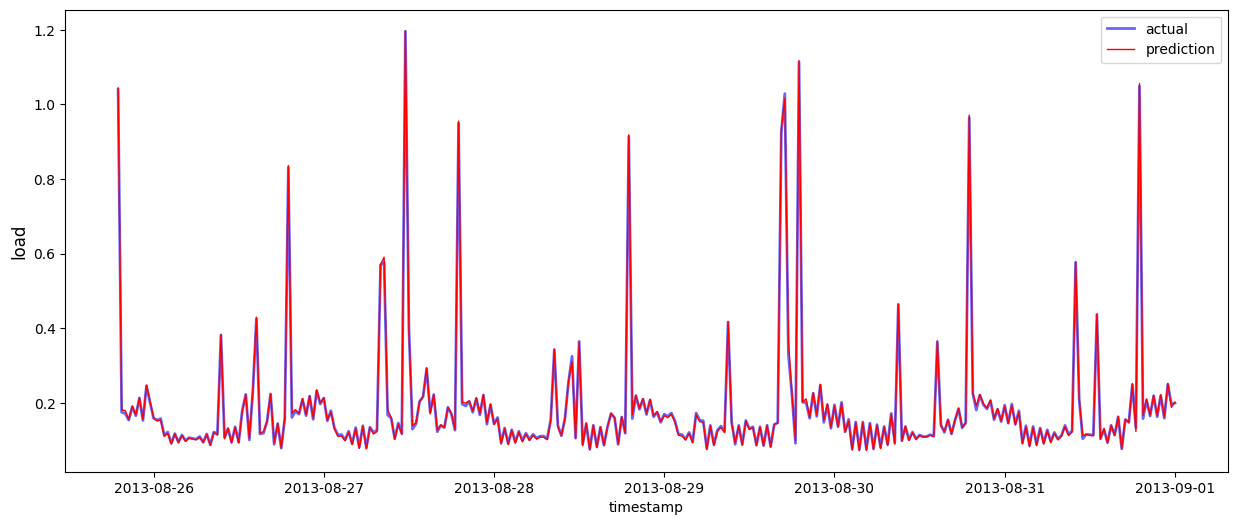

In [12]:
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test.index, y_pred, color = 'red', linewidth=1.0)
plt.legend(['actual','prediction'])
plt.xlabel('timestamp')
plt.ylabel('load', fontsize=12)
plt.show()